In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np
import os
import scvi

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

Global seed set to 0


In [2]:
DIR2SAVE = Path(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/TNKILC/final/"
)
DIR2SAVE.mkdir(parents=True, exist_ok=True)

In [3]:
FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [4]:
adata_tnkilc = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/TNKILC/Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_TNKILC_clustering_annotations.h5ad"
)

In [5]:
adata_tnkilc.obs.Annotation_scVI_detailed.value_counts()

CD4 Th          7802
Treg            7655
CD8 Tex         7531
CD4 Th HSP      7246
CD8 Tem         7079
CD8 Tem HSP     6178
CD4-CD8         5159
CD4 Tn          4778
MAIT            4463
NKT             3695
NK              3191
CD4 Tfh         3010
CD8 Tem GZMB    2239
CD4 Th17        1937
T cycling       1774
gdT             1761
Name: Annotation_scVI_detailed, dtype: int64

In [6]:
adata_tnkilc.obs[["Annotation_scVI_detailed", "cell_source"]].groupby(
    ["Annotation_scVI_detailed", "cell_source"]
).size()

Annotation_scVI_detailed  cell_source
CD4 Th                    BCI-Nuclei       13
                          Che-Cells      3971
                          Wu-Cells       3818
Treg                      BCI-Nuclei      196
                          Che-Cells      4829
                          Wu-Cells       2630
CD8 Tex                   BCI-Nuclei      125
                          Che-Cells      5220
                          Wu-Cells       2186
CD4 Th HSP                BCI-Nuclei        1
                          Che-Cells      3541
                          Wu-Cells       3704
CD8 Tem                   BCI-Nuclei       37
                          Che-Cells      2242
                          Wu-Cells       4800
CD8 Tem HSP               BCI-Nuclei       12
                          Che-Cells      4367
                          Wu-Cells       1799
CD4-CD8                   BCI-Nuclei      859
                          Che-Cells      1641
                          Wu-Cells       2

### Load NK clustering result

In [7]:
adata_nk = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/TNKILC/NK/Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_NK_clustering.h5ad"
)

In [8]:
adata_nk.obs.shape

(6876, 18)

In [9]:
adata_nk.obs.Annotation_scVI_detailed_NK.value_counts()

NK1    3178
NK2    2321
NKT    1377
Name: Annotation_scVI_detailed_NK, dtype: int64

### Load CD4 CD8 clustering result

In [10]:
adata_cd4_cd8 = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Metastatic_CRC_LM_dataset/subpopulations/TNKILC/CD4_C8_cluster/Multiome_Che_Wu_CRC_LM_integrated_scvi_hvg_CD4_CD8_clustering.h5ad"
)

In [11]:
adata_cd4_cd8.obs.shape

(5157, 17)

In [12]:
adata_cd4_cd8.obs.Annotation_scVI_detailed_CD4_CD8.value_counts()

CD4 Th          2523
CD8 Tem         1604
CD8 Tem GZMB    1030
Name: Annotation_scVI_detailed_CD4_CD8, dtype: int64

### Add NK annotations to group

In [13]:
# add NK annotations to adata_tnkilc object by merging
adata_tnkilc.obs = adata_tnkilc.obs.merge(
    adata_nk.obs[["Annotation_scVI_detailed_NK"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("", "_NK"),
)

In [14]:
adata_tnkilc.obs

,Patient,Sample,Cell_type,Cell_subtype,Tissue,Therapy,doublet_score,n_genes_by_counts,total_counts,pct_counts_mt,...,S_score,G2M_score,phase,cell_cycle_diff,_scvi_batch,_scvi_labels,leiden_scVI,leiden_scVI_r1,Annotation_scVI_detailed,Annotation_scVI_detailed_NK
CRC01_LM#GATGACTTCCTGCGAA-1-BCI-Nuclei,CRC01,CRC01_LM,T-NK-ILC,No annotation,LM,NAC,0.000152,714,911.0,8.122942,...,0.085239,0.079083,S,0.006156,0,0,1,4,Treg,NaN
CRC02_LM#AAACGGATCTCCTCAA-1-BCI-Nuclei,CRC02,CRC02_LM,T-NK-ILC,No annotation,LM,naive,0.000418,2143,4883.0,6.102806,...,-0.092766,-0.021338,G1,-0.071428,0,0,5,6,CD8 Tem HSP,NaN
CRC02_LM#AACAAAGGTGGAGCAA-1-BCI-Nuclei,CRC02,CRC02_LM,T-NK-ILC,No annotation,LM,naive,0.002224,1880,3513.0,6.177057,...,-0.080097,-0.094501,G1,0.014404,0,0,7,6,CD4-CD8,NaN
CRC02_LM#AACCGGCTCTGTGCAG-1-BCI-Nuclei,CRC02,CRC02_LM,T-NK-ILC,No annotation,LM,naive,0.045775,1616,2781.0,7.874865,...,-0.056267,0.073756,G2M,-0.130023,0,0,2,3,CD8 Tex,NaN
CRC02_LM#AAGTCTATCCCGCCTA-1-BCI-Nuclei,CRC02,CRC02_LM,T-NK-ILC,No annotation,LM,naive,0.007367,1450,2507.0,4.347826,...,0.005801,-0.098606,S,0.104406,0,0,7,6,CD4-CD8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P20_Liver_T_CACTGGGTCATTACCT-1-Wu-Cells,Wu2021_P20,P20_Liver_T,Treg,FOXP3+ Treg,LM,NAC,0.055944,446,673.0,5.200594,...,-0.067959,-0.059104,G1,-0.008854,0,0,1,4,Treg,NaN
P7_Liver_T2_ACATTTCCACCATTCC-Wu-Cells,Wu2021_P7,P7_Liver_T2,CD8,FGFBP2+ GZMB+ CD8+ T cells,LM,NAC,0.040000,1160,2637.0,1.327266,...,-0.087511,0.012093,G2M,-0.099604,0,0,4,1,CD8 Tem,NaN
P9_Liver_T2_GATCCCTCACCTGATA-Wu-Cells,Wu2021_P9,P9_Liver_T2,CD8,HSP+ CD8+ T cells,LM,NAC,0.103448,1166,2763.0,4.089757,...,-0.036216,0.059375,G2M,-0.095591,0,0,4,1,CD8 Tem,NaN
P6_Liver_T_TTCTGTAGTATCACCA-Wu-Cells,Wu2021_P6,P6_Liver_T,NK,GZMB+ NK cells,LM,naive,0.133690,864,1633.0,4.347826,...,0.060288,-0.040617,S,0.100905,0,0,10,8,NKT,NK1


Notice that col `Annotation_scVI_detailed_NK` has NaN values for myeloid cell annotation, need to fill the nan with myeloid cell annotations from `Annotation_scVI_detailed`

In [15]:
adata_tnkilc.obs.Annotation_scVI_detailed_NK = np.where(
    adata_tnkilc.obs.Annotation_scVI_detailed_NK.isna(),  # where NaN values in NK annot
    adata_tnkilc.obs.Annotation_scVI_detailed,  # put T annotations
    adata_tnkilc.obs.Annotation_scVI_detailed_NK,
)  # keep NK annotations

adata_tnkilc.obs.Annotation_scVI_detailed_NK = (
    adata_tnkilc.obs.Annotation_scVI_detailed_NK.astype("category")
)

In [17]:
adata_tnkilc.obs.drop(
    columns="Annotation_scVI_detailed", inplace=True
)  # drop annotations

In [18]:
# rename annotations column
adata_tnkilc.obs.rename(
    columns={"Annotation_scVI_detailed_NK": "Annotation_scVI_detailed"}, inplace=True
)

### Add CD4 CD8 annotations to group

In [20]:
# add NK annotations to adata_tnkilc object by merging
adata_tnkilc.obs = adata_tnkilc.obs.merge(
    adata_cd4_cd8.obs[["Annotation_scVI_detailed_CD4_CD8"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("", "_CD4_CD8"),
)

In [22]:
adata_tnkilc.obs.Annotation_scVI_detailed_CD4_CD8 = np.where(
    adata_tnkilc.obs.Annotation_scVI_detailed_CD4_CD8.isna(),  # where NaN values in NK annot
    adata_tnkilc.obs.Annotation_scVI_detailed,  # put T annotations
    adata_tnkilc.obs.Annotation_scVI_detailed_CD4_CD8,
)  # keep NK annotations

adata_tnkilc.obs.Annotation_scVI_detailed_CD4_CD8 = (
    adata_tnkilc.obs.Annotation_scVI_detailed_CD4_CD8.astype("category")
)

In [24]:
adata_tnkilc.obs.drop(
    columns="Annotation_scVI_detailed", inplace=True
)  # drop annotations

In [25]:
# rename annotations column
adata_tnkilc.obs.rename(
    columns={"Annotation_scVI_detailed_CD4_CD8": "Annotation_scVI_detailed"},
    inplace=True,
)

In [27]:
adata_tnkilc.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['CD4 Tfh',
 'CD4 Th',
 'CD4 Th HSP',
 'CD4 Th17',
 'CD4 Tn',
 'CD4-CD8',
 'CD8 Tem',
 'CD8 Tem GZMB',
 'CD8 Tem HSP',
 'CD8 Tex',
 'MAIT',
 'NK',
 'NK1',
 'NK2',
 'NKT',
 'T cycling',
 'Treg',
 'gdT']

### Need to rremove cells labeled "NK" as these were removed as less than 3 per patient

In [28]:
adata_tnkilc.obs.Annotation_scVI_detailed.value_counts()

CD4 Th          10325
CD8 Tem          8683
Treg             7655
CD8 Tex          7531
CD4 Th HSP       7246
CD8 Tem HSP      6178
CD4 Tn           4778
MAIT             4463
CD8 Tem GZMB     3269
NK1              3178
CD4 Tfh          3010
NK2              2321
CD4 Th17         1937
T cycling        1774
gdT              1761
NKT              1380
NK                  7
CD4-CD8             2
Name: Annotation_scVI_detailed, dtype: int64

In [29]:
adata_tnkilc.obs[["Annotation_scVI_detailed", "cell_source"]].groupby(
    ["Annotation_scVI_detailed", "cell_source"]
).size()

Annotation_scVI_detailed  cell_source
CD4 Tfh                   BCI-Nuclei      135
                          Che-Cells      1772
                          Wu-Cells       1103
CD4 Th                    BCI-Nuclei      409
                          Che-Cells      4832
                          Wu-Cells       5084
CD4 Th HSP                BCI-Nuclei        1
                          Che-Cells      3541
                          Wu-Cells       3704
CD4 Th17                  BCI-Nuclei       29
                          Che-Cells       309
                          Wu-Cells       1599
CD4 Tn                    BCI-Nuclei       34
                          Che-Cells      2233
                          Wu-Cells       2511
CD4-CD8                   BCI-Nuclei        2
                          Che-Cells         0
                          Wu-Cells          0
CD8 Tem                   BCI-Nuclei      336
                          Che-Cells      2665
                          Wu-Cells       5

In [30]:
### which patients have NK label?
adata_tnkilc[
    adata_tnkilc.obs["Annotation_scVI_detailed"] == "NK"
].obs.Patient.value_counts()

CRC02    2
CRC11    2
CRC04    1
CRC08    1
CRC14    1
Name: Patient, dtype: int64

In [31]:
# remove them as they have not been annotated as they are too few cells per patient
adata_tnkilc = adata_tnkilc[adata_tnkilc.obs.Annotation_scVI_detailed != "NK"].copy()

In [32]:
# remove them as they have not been annotated as they are too few cells per patient
adata_tnkilc = adata_tnkilc[
    adata_tnkilc.obs.Annotation_scVI_detailed != "CD4-CD8"
].copy()

In [33]:
adata_tnkilc.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['CD4 Tfh',
 'CD4 Th',
 'CD4 Th HSP',
 'CD4 Th17',
 'CD4 Tn',
 'CD8 Tem',
 'CD8 Tem GZMB',
 'CD8 Tem HSP',
 'CD8 Tex',
 'MAIT',
 'NK1',
 'NK2',
 'NKT',
 'T cycling',
 'Treg',
 'gdT']

### Add colours for plot

In [34]:
adata_tnkilc.uns["Annotation_scVI_detailed_colors"] = [
    "#1f78b4",
    "#fa9fb5",
    "#beaed4",
    "#fdbf6f",
    "#b15928",
    "#e31a1c",
    "#fc9272",
    "#800026",
    "#ff7f00",
    "#7fc97f",
    "#1d91c0",
    "#dd3497",
    "#a6cee3",
    "#ffff99",
    "#33a02c",
    "#6a3d9a",
]

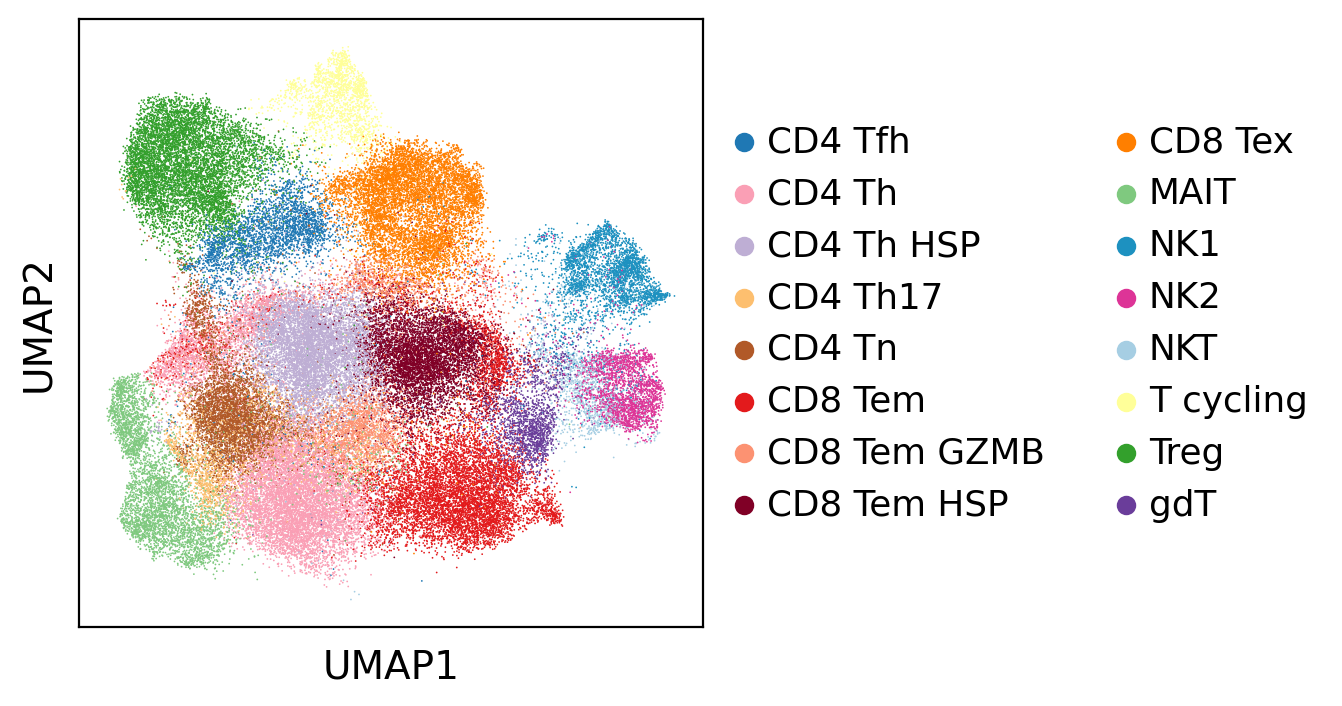

In [35]:
sc.pl.umap(
    adata_tnkilc, color="Annotation_scVI_detailed", save="annotations.pdf", title=""
)

In [36]:
# set colours for dataset, need to know order
adata_tnkilc.obs.Annotation_scVI_detailed.cat.categories.values.tolist()

['CD4 Tfh',
 'CD4 Th',
 'CD4 Th HSP',
 'CD4 Th17',
 'CD4 Tn',
 'CD8 Tem',
 'CD8 Tem GZMB',
 'CD8 Tem HSP',
 'CD8 Tex',
 'MAIT',
 'NK1',
 'NK2',
 'NKT',
 'T cycling',
 'Treg',
 'gdT']

In [37]:
# todo dotplot with all cell types annotated
markers = {
    "T": ["TRAC"],
    "CD4": ["CD4"],
    "CD8": ["CD8A", "CD8B"],
    "Cycling": ["MKI67"],
    "Treg": ["FOXP3", "CTLA4", "IL2RA"],
    "Exhausted T": [
        "PDCD1",
        "LAG3",
        "HAVCR2",
        "CTLA4",
        "TIGIT",
        "ENTPD1",
    ],  # PD1: PCDC1, TIM3: HAVCR2,  CD39:ENTPD1 https://www.nature.com/articles/s41467-021-23324-4
    "NK": ["NCAM1", "FCER1G", "KLRC1"],
    "ILC": ["AREG", "TLE1", "IL4I1"],
    "Th": ["IL7R", "CD40LG", "ANXA1"],
    "Tfh": ["ITM2A", "LPAR6", "PDCD1"],
    "Naïve CD4 T": ["CCR7", "SELL", "TCF7", "LEF1"],
    "Th17": ["IL17A", "ODF2L", "IL7R", "PDE4D"],
    "Tem CD8": ["CCL4", "CCL5", "GZMK", "GZMB"],
    "gdT": ["TRDC", "TRGC1", "ITGA1"],
    "ILC3": ["IL4I1", "RORC", "TNFRSF25", "SPINK2", "KLRB1", "IL7R"],
    "NKT": ["KLRB1", "CD3G", "FGFBP2"],
    "MAIT": ["SLC4A10", "NCR3", "KLRB1"],
}

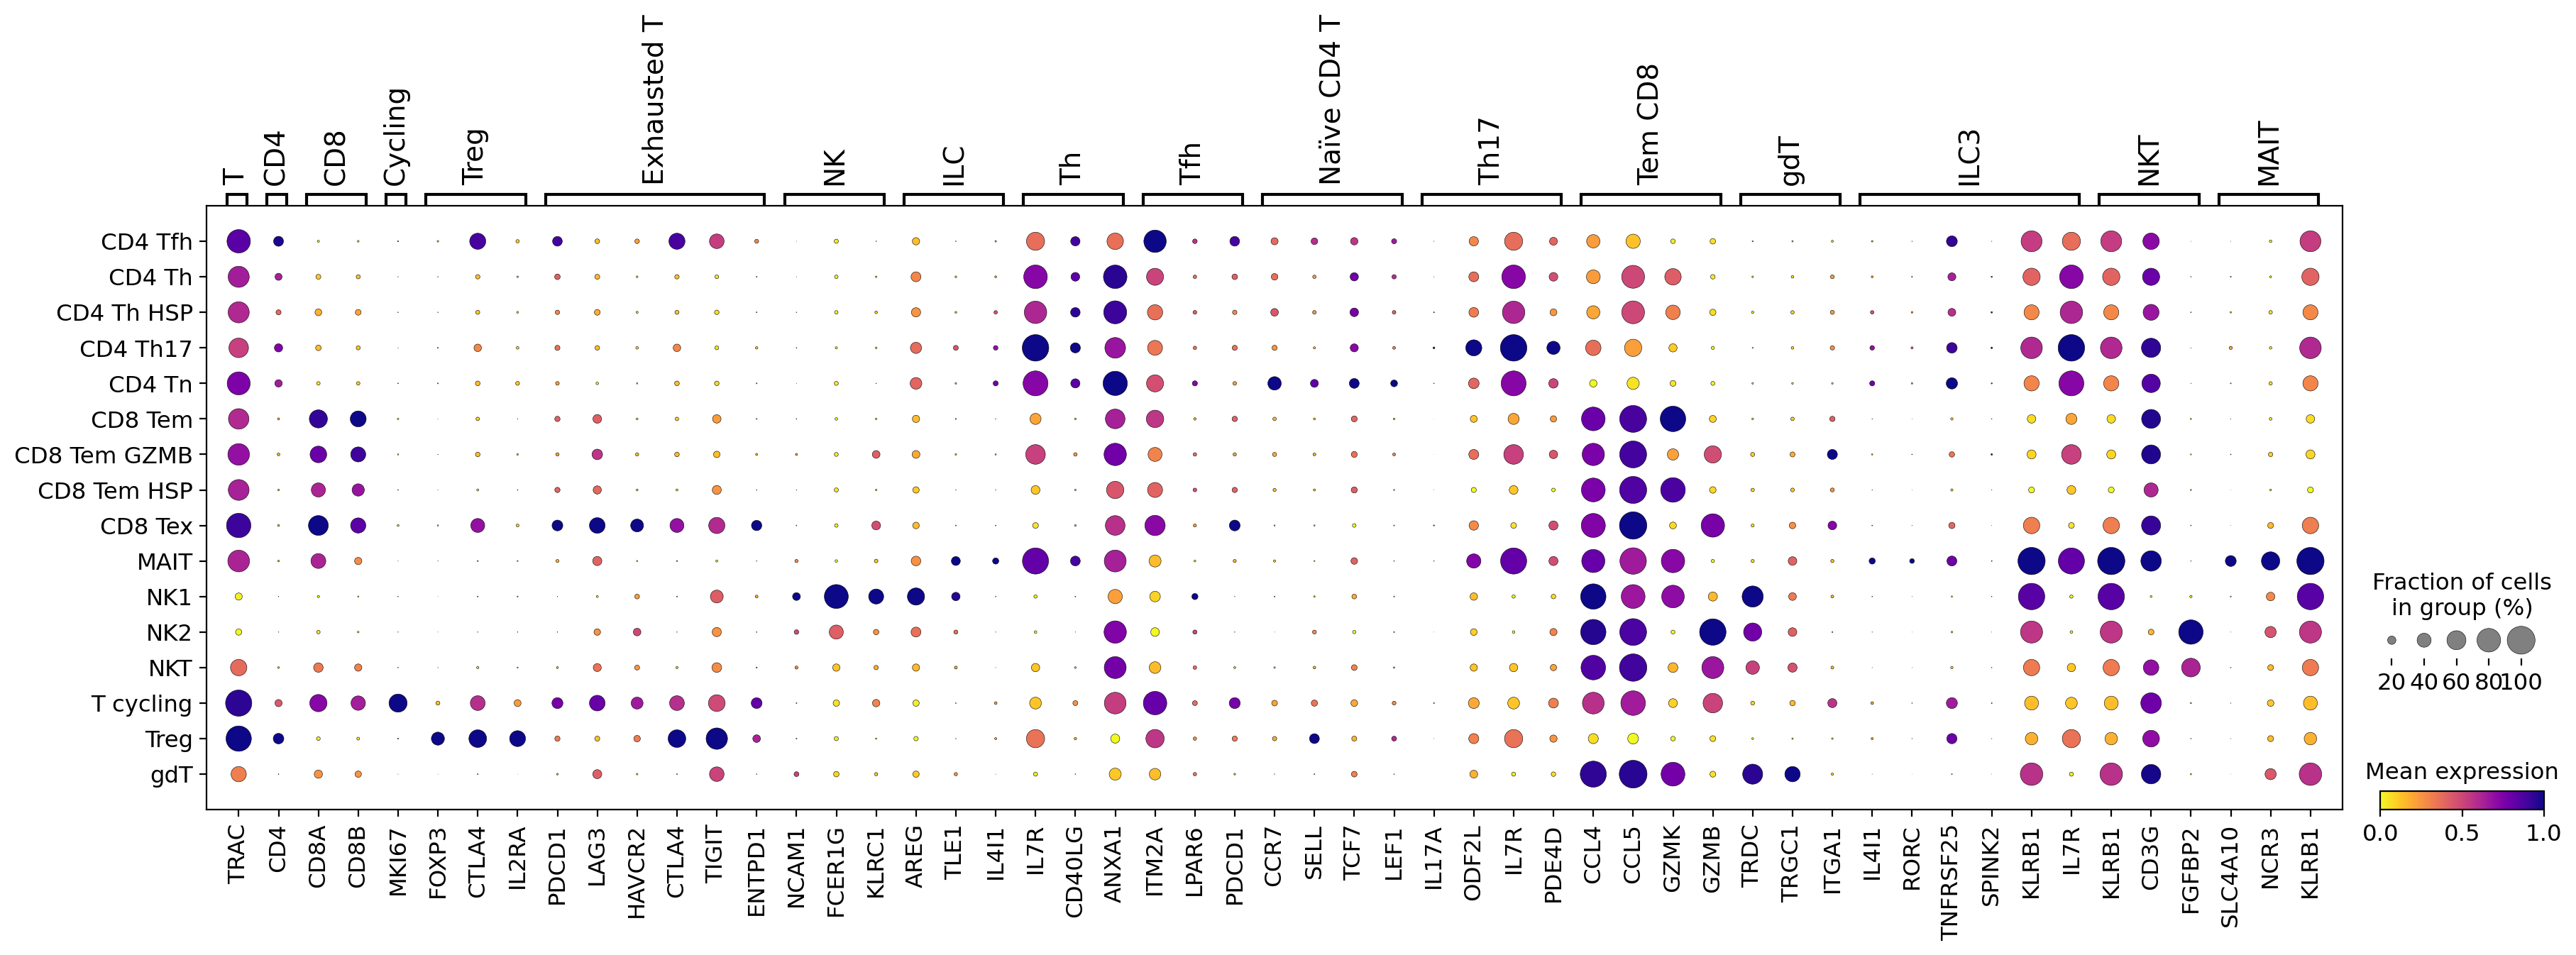

In [38]:
sc.pl.dotplot(
    adata_tnkilc,
    groupby="Annotation_scVI_detailed",
    use_raw=True,
    var_names=markers,
    cmap="plasma_r",
    standard_scale="var",
    vmin=0,
    vmax=1,
    colorbar_title="Mean expression",
    dendrogram=False,
    save="TNKILC_dotplot_mean_general_annot.pdf",
    show=True,
)

### Write to file

In [40]:
# save object
# write to file
adata_tnkilc.write(
    DIR2SAVE.joinpath("CRC_LM_decon_scvi_hvg_TNKILC_NK_clustering_final.h5ad")
)